In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import re
import warnings
warnings.filterwarnings('ignore')
# wczytanie ramki danych ze zliczonymi wystąpieniami słów
df = pd.read_csv('AsianReligionsData/AllBooks_baseline_DTM_Labelled.csv')
df

,Unnamed: 0,foolishness,hath,wholesome,takest,feelings,anger,vaivaswata,matrix,kindled,...,erred,thinkest,modern,reigned,sparingly,visual,thoughts,illumines,attire,explains
0,Buddhism_Ch1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Buddhism_Ch2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Buddhism_Ch3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Buddhism_Ch4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Buddhism_Ch5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,BookOfWisdom_Ch15,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
586,BookOfWisdom_Ch16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
587,BookOfWisdom_Ch17,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
588,BookOfWisdom_Ch18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
p = r'[A-Za-z]+'
book = re.compile(p)
books = list(map(lambda x: book.match(x).group(), df[df.columns[0]]))
df['book'] = books

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['book'] = le.fit_transform(df['book'])

In [64]:
# wczytanie tekstów
with open('AsianReligionsData/Complete_data.txt', 'r',encoding='latin-1') as file:
    text = file.read()
text = re.split(r'\n\d\.\d+\n', text)
text = [re.sub(r'\d\.\d+\n','',i) for i in text]

In [65]:
# podział na słowa
word = re.compile(r'\b([A-Za-z]+)\b')
words = list(map(word.findall, text))

In [66]:
# podział na zdania
sentence = re.compile(r'\b([A-Z].*?[.!?]+)[\b\s\W]')
sentences = list(map(sentence.findall, text))

In [67]:
# obliczenie pewnych statystyk
n_words = [len(x) for x in words] # liczba słów w rozdziale
mean_word_len = [np.mean(list(map(len, x))) for x in words] # średnia długość słowa w rozdziale (w literach)
n_sentences = [len(x) for x in sentences] # liczba zdań w rozdziale
mean_sentence_len = [np.mean(list(map(lambda x:len(word.findall(x)), x))) for x in sentences] # średnia długość zdania w rozdziale (w słowach)

In [68]:
# poprawki
mean_word_len[13] = 0.0
mean_sentence_len[13] = 0.0
n_sentences[145] = 1
mean_sentence_len[145] = float(len(word.findall(text[145])))

In [69]:
# dodanie do ramki danych
df['n_words'] = n_words
df['mean_word_len'] = mean_word_len
df['n_sentences'] = n_sentences
df['mean_sentence_len'] = mean_sentence_len

In [76]:
from sklearn.manifold import TSNE
random_state = 1500100900
tSNE = TSNE(random_state=random_state, verbose=1)
digits_proj = tSNE.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 590 samples in 0.070s...
[t-SNE] Computed neighbors for 590 samples in 0.153s...
[t-SNE] Computed conditional probabilities for sample 590 / 590
[t-SNE] Mean sigma: 7.398887
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.724728
[t-SNE] KL divergence after 1000 iterations: 0.257549


In [71]:
def scatter(x, colors):
    palette = np.array(sns.color_palette("hls", 10))

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add labels
    txts = []
    for i in range(8):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, list(le.classes_)[i], fontsize=24)
        txts.append(txt)

    return f, ax, sc, txts

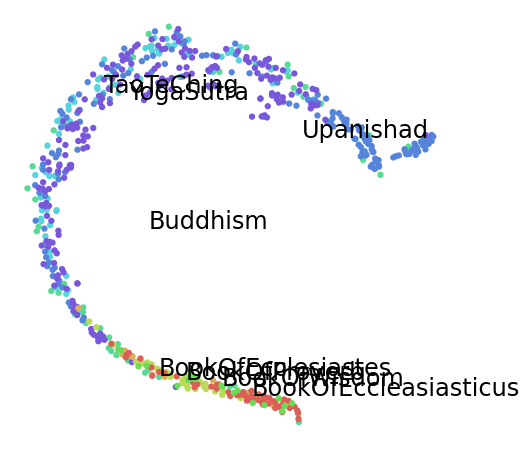

In [75]:
scatter(digits_proj, df['book'])
plt.show()

# Modelowanie

In [84]:
# testowanie trzech modeli z silhouette score
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

def test_models(X):
    max_clusters = 15
    scores = [[],[],[]]
    for k in range(2, max_clusters):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmedoids = KMedoids(n_clusters=k, random_state=0)
        agglomerative = AgglomerativeClustering(n_clusters=k, linkage = 'ward')
    
        labels_kmeans = kmeans.fit_predict(X)
        labels_kmedoids = kmedoids.fit_predict(X)
        labels_agglomerative = agglomerative.fit_predict(X)
    
        wcss_kmeans = silhouette_score(X, labels_kmeans)
        wcss_kmedoids = silhouette_score(X, labels_kmedoids)
        wcss_agglomerative = silhouette_score(X, labels_agglomerative)
    
        scores[0].append(wcss_kmeans)
        scores[1].append(wcss_kmedoids)
        scores[2].append(wcss_agglomerative)
        
    plt.figure(figsize=(8,6))
    x = range(2,max_clusters)

    plt.plot(x, scores[0], label = 'kmeans')
    plt.plot(x, scores[1], label = 'kmedoids')
    plt.plot(x, scores[2], label = 'agglomerative')

    plt.xlabel('n_clusters')
    plt.ylabel('silhouette_score')

    plt.title(f"Silhouette scores for 2 to {max_clusters - 1} clasters")
    plt.legend()

    plt.show()

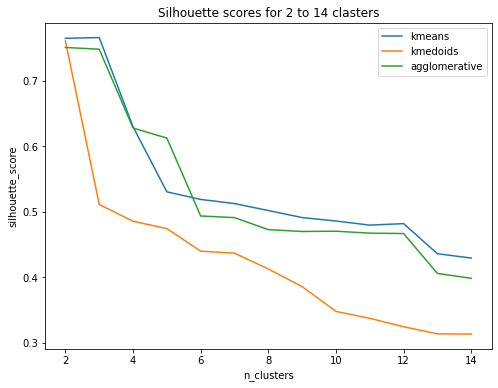

In [86]:
X = df[df.columns[1:-1]]
test_models(X)

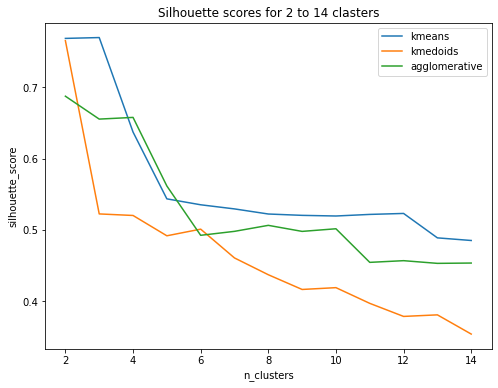

In [85]:
columns = ['n_words', 'mean_word_len', 'n_sentences', 'mean_sentence_len']
X = df[columns]
test_models(X)

Text(0, 0.5, 'Cumulative explained variance')

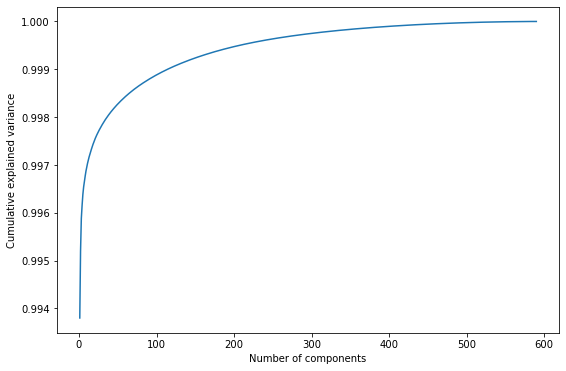

In [87]:
from sklearn.decomposition import PCA
X = df[df.columns[1:]]
pca = PCA().fit(X)

plt.figure(figsize=(9,6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

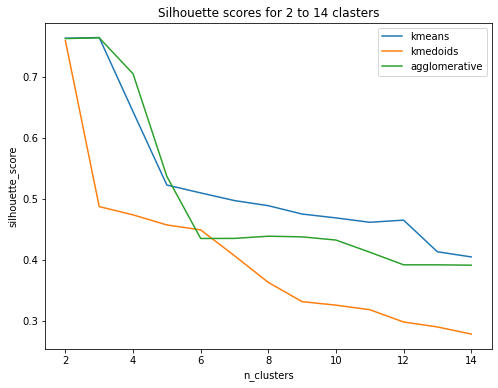

In [88]:
pca = PCA(n_components=300)
X = pca.fit_transform(X)
test_models(X)

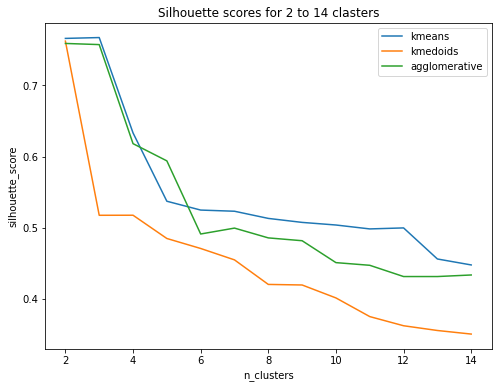

In [90]:
# ograniczenie liczby kolumn
l = []
for i in df.columns[1:-1]:
    if sum(df[i] != 0) > 10: # liczba wierszy z niererowymi wartościami dla każdego słowa
        l.append(i)
X = df[l]
test_models(X)